In [1]:
#-*- coding:utf8 -*-
import os
os.environ['OMP_NUM_THREADS']='1'

In [2]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pickle, time
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool

plt.style.use('ggplot')

## 函数定义

In [3]:
def gradient(theta, segs):
    result = []
    N = features.shape[0]
    batch_sz = N//segs
    for i in range(features.shape[1]): #对每一个特征
        X1 = deepcopy(features)
        X1 = X1[X1[:,i].argsort()]
        X1[:,i] += 1e-4
        X2 = deepcopy(features)
        X2 = X2[X2[:,i].argsort()]
        X2[:,i] -= 1e-4
        for j in range(segs): #对每一个区间
            pred1 = unpack_theta_get_outputs(X1[batch_sz*j:batch_sz*(j+1)], theta)
            pred2 = unpack_theta_get_outputs(X2[batch_sz*j:batch_sz*(j+1)], theta)
            g = (pred1 - pred2) / 2e-4    # 梯度
            result.append(np.mean(g))
    return result    

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def np_neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2):
    h = np.tanh(np.matmul(X, W_0) + b_0)
    h = np.tanh(np.matmul(h, W_1) + b_1)
    #h = sigmoid(np.matmul(h, W_2) + b_2)
    h = np.matmul(h, W_2) + b_2
    return np.reshape(h, [-1])

# def unpack_theta_get_outputs(X, theta):
#     W_0 = np.reshape(theta[0:9*40], [9, 40])
#     W_1 = np.reshape(theta[9*40: 9*40+40*10], [40, 40])
#     W_2 = np.reshape(theta[9*40+40*40: 9*40+40*40+40*1], [40, 1])
#     bs = 9*40+40*40+40*1
#     b_0 = np.reshape(theta[bs:bs+40], [40])
#     b_1 = np.reshape(theta[bs+40:bs+40+40], [40])
#     b_2 = np.reshape(theta[bs+40+40:], [1])
#     return np_neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2)

def unpack_theta_get_outputs(X, theta):
    W_0 = np.reshape(theta[0:9*7], [9, 7])
    W_1 = np.reshape(theta[9*7: 9*7+7*10], [7, 10])
    W_2 = np.reshape(theta[9*7+7*10: 9*7+7*10+10*1], [10, 1])
    bs = 9*7+7*10+10*1
    b_0 = np.reshape(theta[bs:bs+7], [7])
    b_1 = np.reshape(theta[bs+7:bs+7+10], [10])
    b_2 = np.reshape(theta[bs+7+10:], [1])
    return np_neural_network(X, W_0, W_1, W_2, b_0, b_1, b_2)

def segment(data, segs):
    # 切分区间，并返回上下界
    results = []
    original_features = data.iloc[:,:-1].values.astype(np.float32)
    N = original_features.shape[0]
    batch_sz = N//segs

    for i in range(original_features.shape[1]):
        original_features = original_features[original_features[:,i].argsort()]
        for j in range(segs):
            results.append((round(original_features[batch_sz*j,i], 2),
                            round(original_features[batch_sz*(j+1)-1,i], 2)))
    return results

def plot_hist(data, ax, bins=50, title=''):
    ax.hist(data, bins=bins)
    mu, sigma = np.mean(data), np.std(data)
    ax.set_title(title+': '+str("%.3f" % mu)+','+str("%.3f" % sigma))
    return mu, sigma

## 数据读取

In [4]:
# read raw data
reg_pre = 'PM2.5_'
data_file = './data/'+reg_pre+'test.csv'
data = pd.read_csv(data_file)
drv_titles = data.columns

# shuffle
data = data.sample(frac=1).reset_index(drop=True)

# # classificatoin
# # split into feature part and target part
# features = data.iloc[:,:-1].values.astype(np.float32)
# targets = data.iloc[:,-1].values
# # change target to binary label
# targets = (targets>=7).astype(np.float32)
# # normalization
# features = StandardScaler().fit_transform(features)

# regression (with data standardized)
# split into feature part and target part
features = data.iloc[:,:-1].values.astype(np.float32)
targets = data.iloc[:,-1].values.astype(np.float32)
N, D = features.shape

J = 20000
B = 5000
theta_pre = 'fb5'
theta_suf = '-2h-10v'
segs = 3

theta_file = './theta/2h-7-10-10v/'+reg_pre+theta_pre+'-'+str(J)+'-'+str(B)+theta_suf
with open(theta_file,'rb') as f:
    outputs = pickle.load(f)

## 偏导计算

In [5]:
## 偏导计算
start = time.time()
G = []
pool = Pool(20)
res = []
for theta in outputs:
    res.append(pool.apply_async(gradient,(theta, segs)))
pool.close()
pool.join()
for r in res:
    G.append(r.get())
G = np.array(G)
print("Gradient Time: ", time.time()- start)
print("Shape of G: ", G.shape)

## 上下界计算
SV = segment(data, segs)

Gradient Time:  127.260969162
Shape of G:  (5000, 27)


In [6]:
## 似然计算
def mse(y, y0):
    assert len(y) == len(y0)
    return np.sum(np.power((y-y0),2))

start = time.time()
L = []
pool = Pool(20)
res = []
for theta in outputs:
    res.append(pool.apply_async(unpack_theta_get_outputs,(features, theta)))
pool.close()
pool.join()
for r in res:
    L.append(mse(targets, r.get()))
L = np.array(L)
print("Liklihood Time: ", time.time() - start)
print("Shape of L: ", L.shape)

Liklihood Time:  12.9922280312
Shape of L:  (5000,)


## 绘图展示

In [7]:
N, D = features.shape

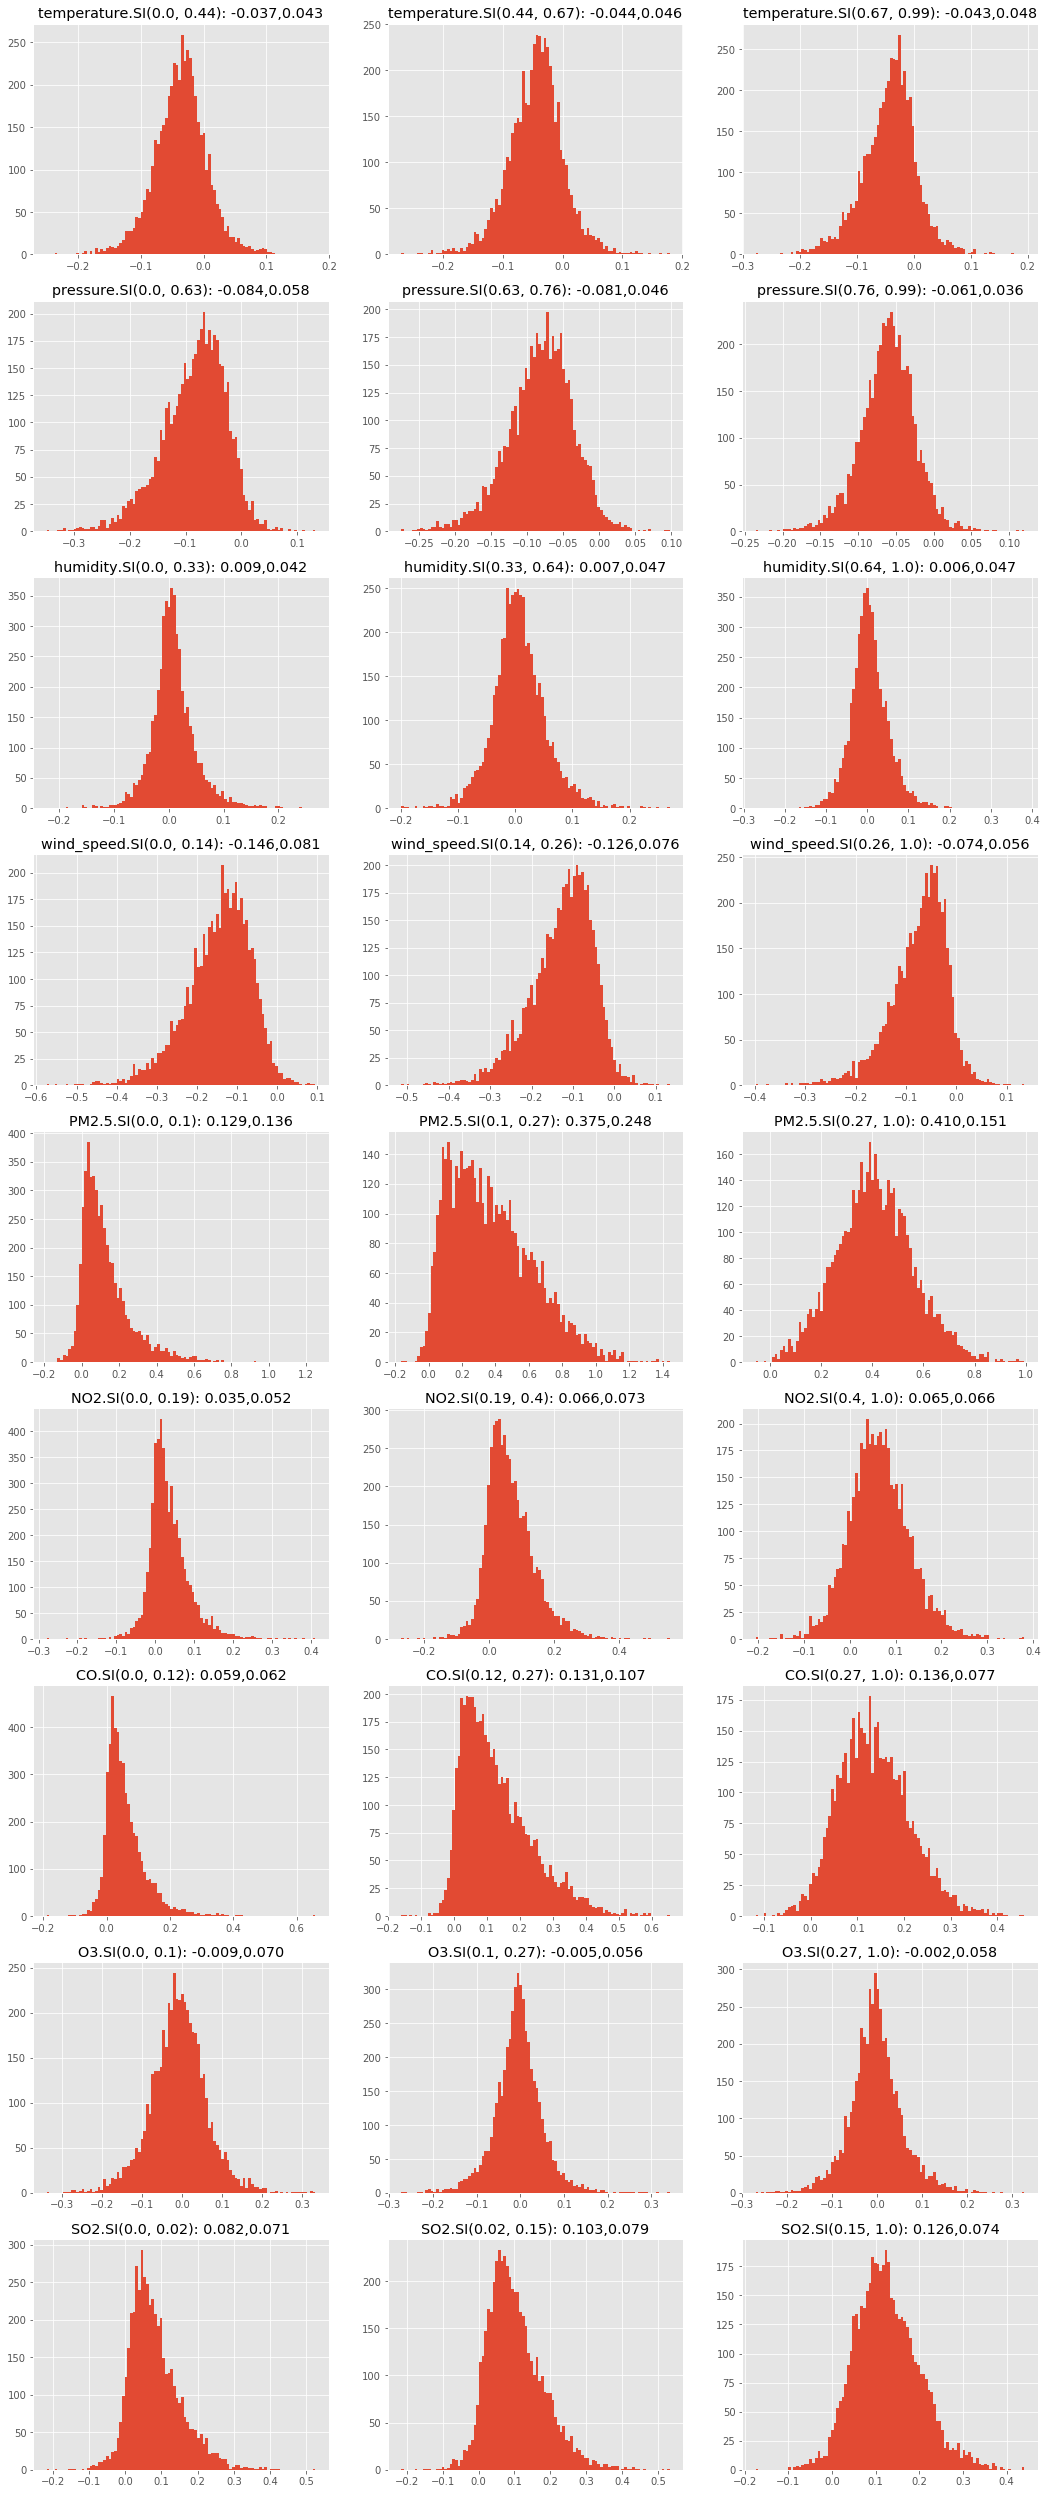

In [8]:
rows, cols = D, segs
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6*cols, 5*rows))
for i in range(rows):
    for j in range(cols):
        if(cols == 1):
            plot_hist(G[:, i*cols+j], axes[i], 100, 
                      title=drv_titles[i]+str(SV[i*cols+j]))
        else:
            plot_hist(G[:, i*cols+j], axes[i, j], 100, 
                      title=drv_titles[i]+str(SV[i*cols+j]))
            
#plt.savefig('./drv_out/2h-7-10-10v/'+reg_pre+theta_pre+'-'+str(J)+'-'+str(B)+theta_suf+'-'+str(segs)+'seg_DIS.png')
plt.show()
plt.close()

In [9]:
## 获得偏均值与置信区间
def get_confidence_interval_with_mean(data, level=95):
    G_mean = np.mean(data, axis=0)

    conf_level = level
    conf_lb = (100 - conf_level) / 2.0
    conf_ub = conf_lb + conf_level
    G_err = np.stack((G_mean - np.percentile(data, conf_lb, axis=0), 
                         np.percentile(data, conf_ub, axis=0) - G_mean), axis=0)
    return G_mean, G_err

G_mean, G_err = get_confidence_interval_with_mean(G, 95)
print(G_err.shape)

(2, 27)


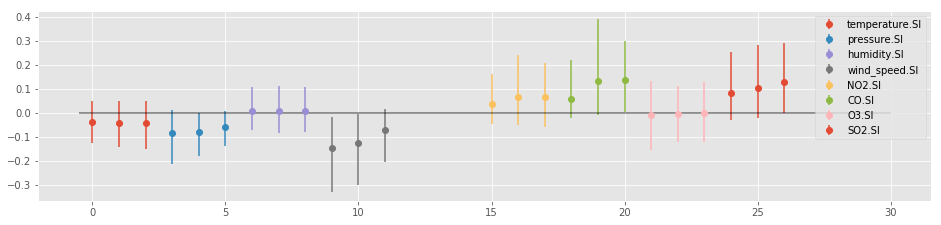

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
scale_ls = range(len(G_mean))
for i in range(D):
    if(drv_titles[i] == reg_pre[:-1]+'.SI'):
        continue
    plt.errorbar(scale_ls[i*segs:(i+1)*segs], G_mean[i*segs:(i+1)*segs], G_err[:,i*segs:(i+1)*segs], fmt='o')
    #print(bar.get_color())
    
legend_labels = drv_titles.drop(labels=[reg_pre[:-1]+'.SI'])
plt.legend(legend_labels[:-1])
plt.hlines(y=0, xmin=scale_ls[0]-0.5, xmax=scale_ls[-1]+4, alpha=0.5)
#plt.savefig('./drv_out/2h-7-10-10v/'+reg_pre+theta_pre+'-'+str(J)+'-'+str(B)+theta_suf+'-'+str(segs)+'seg_CONF.png')
#plt.xticks(scale_ls, index_ls)
plt.show()

In [11]:
# rows, cols = D, segs
# index_ls = []
# for i in range(rows):
#     for j in range(cols):
#         index_ls.append(drv_titles[i]+str(SV[i*cols+j]))
# index_ls

In [12]:
from sklearn.neighbors import KernelDensity
def plot_density(x, y, ax, bw=0.25, title=''):
    X_kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(x.reshape(-1,1))
    X_est = np.exp(X_kde.score_samples(x.reshape(-1,1)))
    ax.scatter(X_est, y)
    ax.set_title(title)
    return 

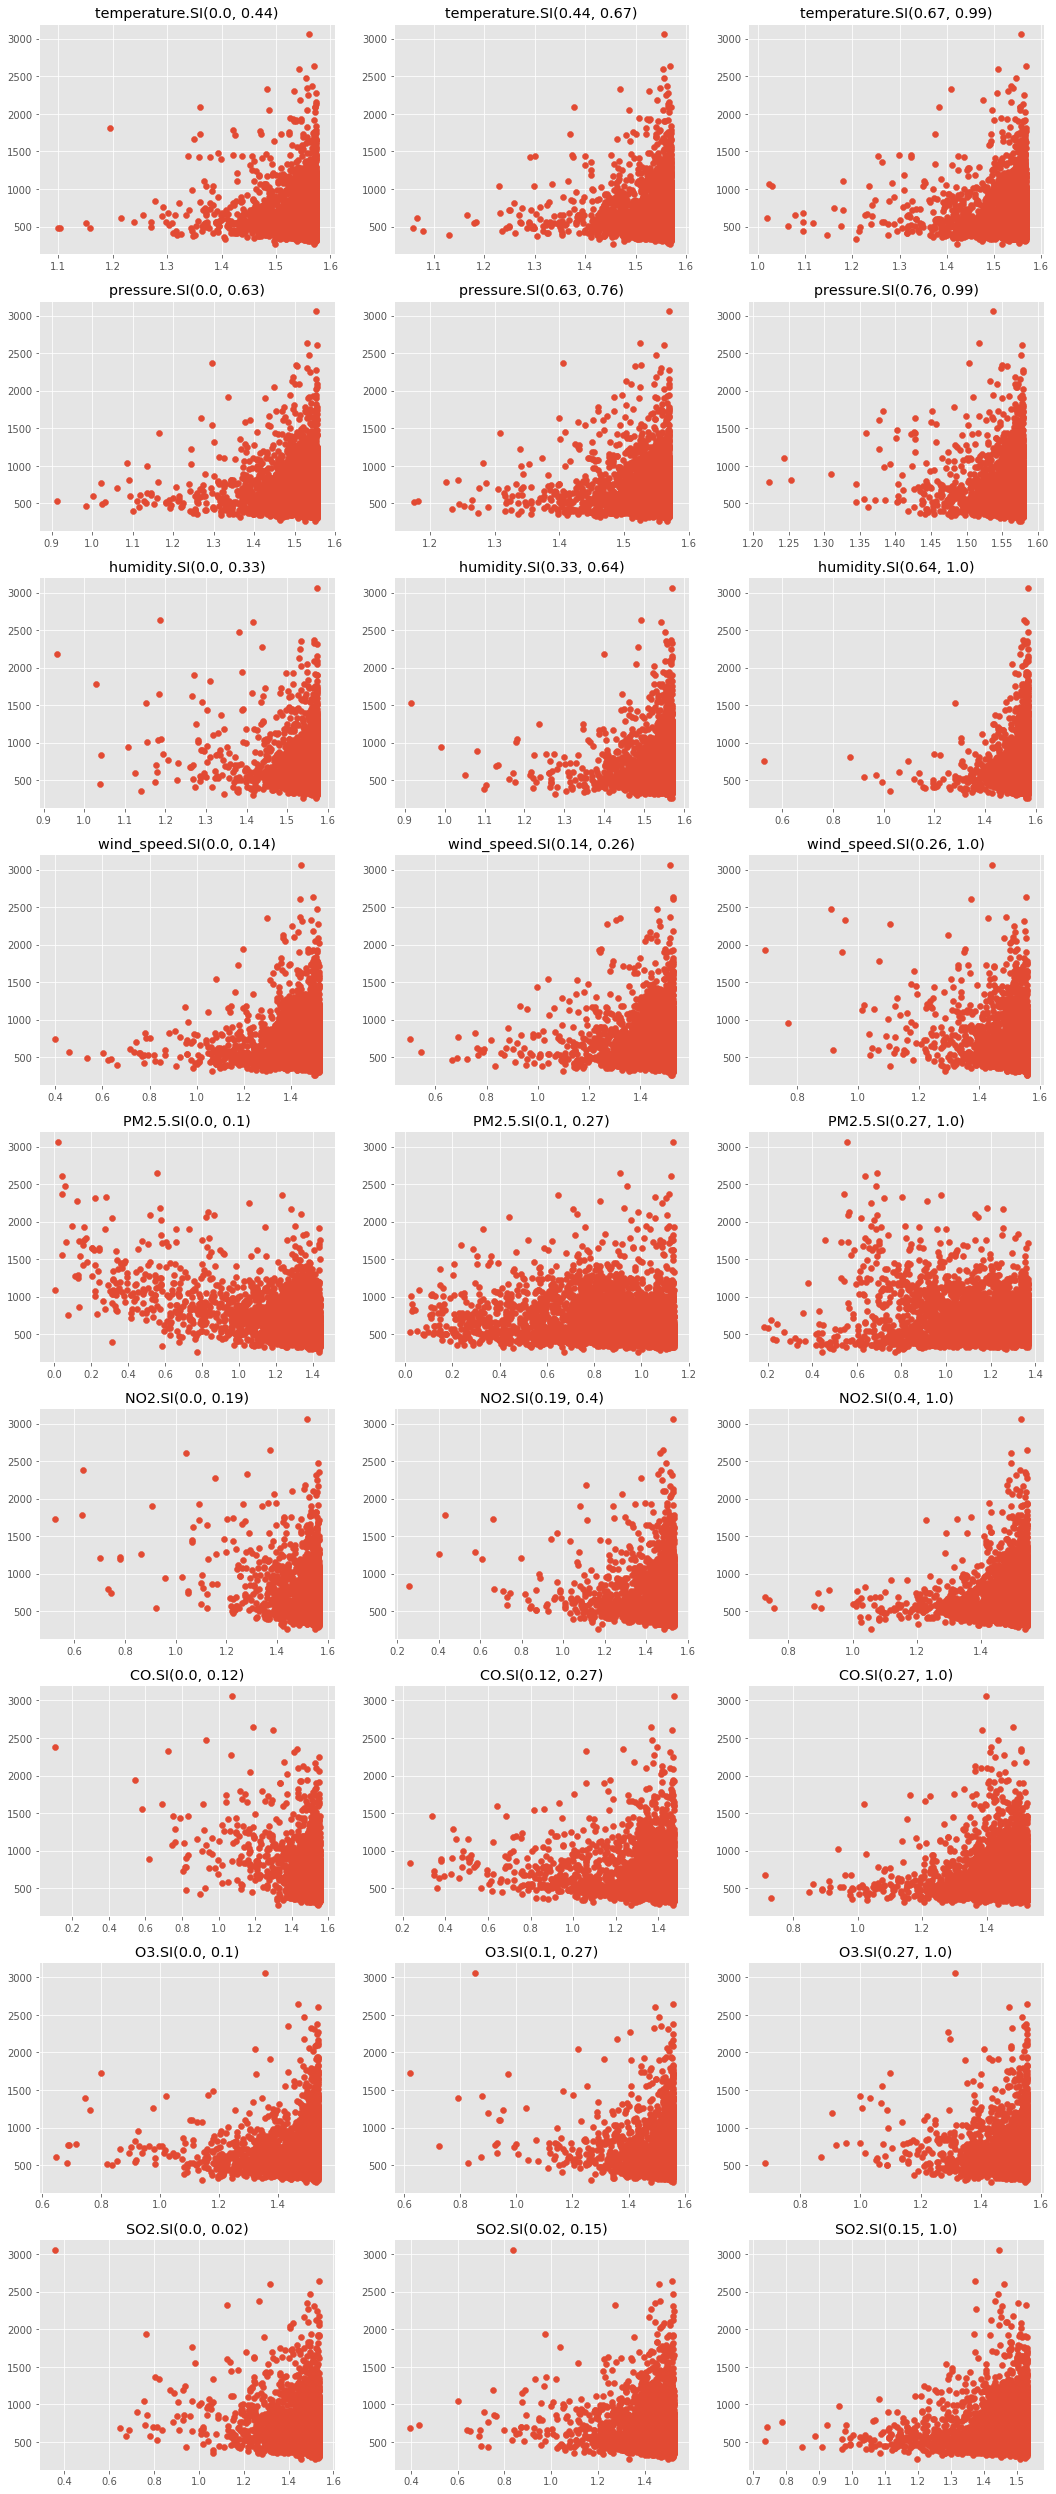

In [13]:
rows, cols = D, segs
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6*cols, 5*rows))
for i in range(rows):
    for j in range(cols):
        if(cols == 1):
            plot_density(G[:, i*cols+j], L, axes[i], 0.25, 
                      title=drv_titles[i]+str(SV[i*cols+j]))
        else:
            plot_density(G[:, i*cols+j], L, axes[i, j], 0.25, 
                      title=drv_titles[i]+str(SV[i*cols+j]))
plt.savefig('./drv_out/2h-7-10-10v/'+reg_pre+theta_pre+'-'+str(J)+'-'+str(B)+theta_suf+'-'+str(segs)+'seg_DENS.png')
plt.show()
plt.close() 